In [1]:
from LoaderTools.libs import LibsLoader
from AnalysisTools.analytics import AnalyticsToolkit
from AnalysisTools import visual
from matplotlib.gridspec import GridSpec


import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1
%autoreload 2

# 1. Intialize Data Handler Module

This module handles data loading, preprocessing tools (baseline removal and normalization), and well as feature extraction

In [4]:
fname = r"E:/Data/Data_LIBS/ForHolo/wrench_map"
data_handler = LibsLoader(fname)
data_handler.load_dataset(baseline_corrected = True)

In [100]:
data_handler.normalize_to_sum()

## 1.1 Feature Extraction

In [102]:
data_handler.automatic_feature_extraction(fft_features = 20,
                                          intens_features = 20,
                                          sigma = 1,
                                          force_recal = True)

Performing the SIR algorithm...
Operation Completed.


# 2. Initialize the Analytics module

This module handles the is used to generate a database of element emission lines, and perform emission line identification

In [5]:
analytics = AnalyticsToolkit()
# analytics.update_elements(['V', 'Fe', 'Na', 'O', 'Cu', 'Al', 'Ag', 'Au', 'Li', 'Ti', 'Cr'])

In [14]:
counts = analytics.identify_from_elements(spectral_cube = data_handler.dataset,
                                            wavelengths = data_handler.wavelengths,
                                            operation = 'average',
                                            min_intensity = 0.1,
                                            return_counts = True)

In [63]:
counts = analytics.identify_on_cluster(spectral_cube = data_handler.dataset,
                                        wavelengths = data_handler.wavelengths,
                                        operation = 'average',
                                        min_intensity = 0.1,
                                        return_counts = True,
                                        cluster_number = 2)

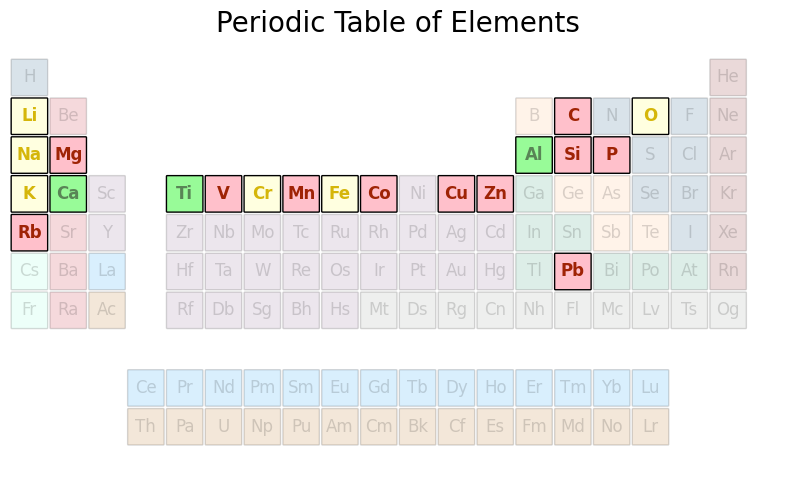

In [64]:
visual.plot_preiodic_table(counts)

In [10]:
counts = analytics.identify_from_features(x_features = data_handler.x_features,
                                            min_intensity = 0.1,
                                            return_counts = True)

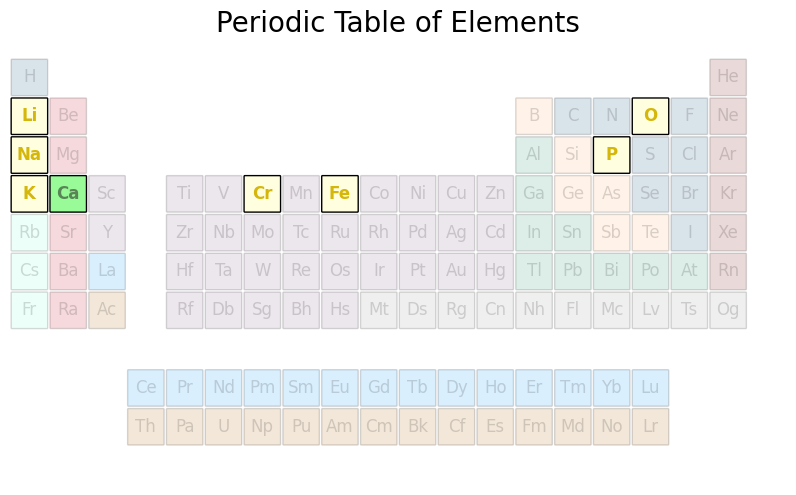

In [11]:
visual.plot_preiodic_table(counts)

## 2.1 Classify

In [108]:
labels = analytics.clustering(model = 'kmeans', 
                               n_clusters = 4, 
                               feature_cube = data_handler.features, 
                               scaler = 'minmax',
                               random_state = 10)

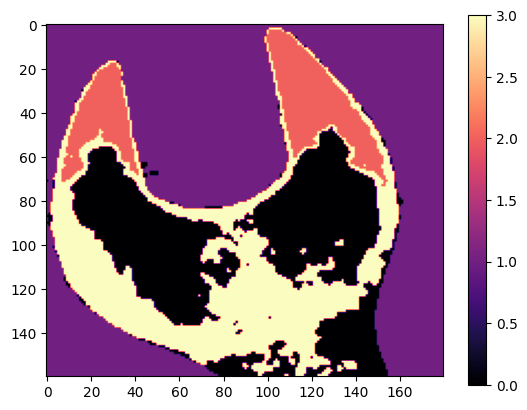

In [109]:
plt.figure()
plt.imshow(labels, cmap = 'magma')
plt.colorbar()

In [128]:
counts = analytics.identify_on_cluster(spectral_cube = data_handler.dataset,
                                       wavelengths = data_handler.wavelengths,
                                       tolerance = 0.05,
                                       min_intensity = 0.1,
                                       return_counts = True,
                                       cluster_number = 2
                                       )

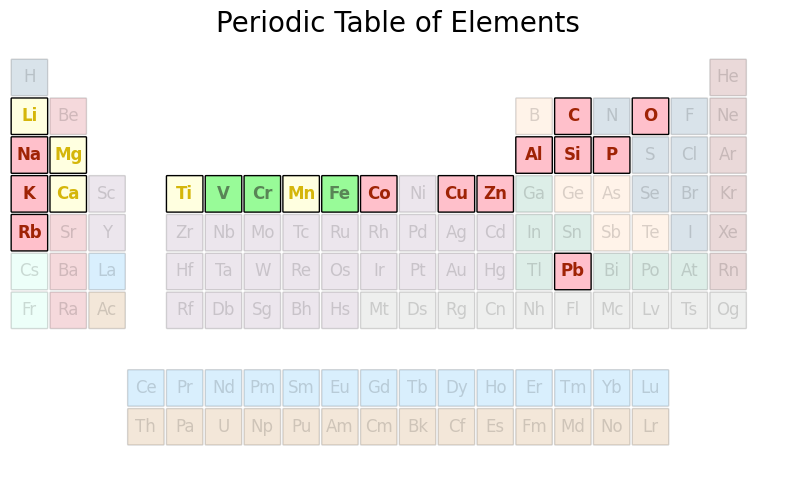

In [181]:
visual.plot_preiodic_table(counts)

# 3. Build an interface

In [23]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import numpy as np
from LoaderTools.libs import LibsLoader
from AnalysisTools.analytics import AnalyticsToolkit
import base64

# Initialize the Dash app
app = dash.Dash(__name__)

# Load and process the spectral data
fname = r"E:/Data/Data_LIBS/ForHolo/wrench_map"
# data_handler = LibsLoader(fname)
# data_handler.load_dataset(baseline_corrected=True)
# data_handler.normalize_to_sum()
# data_handler.automatic_feature_extraction(fft_features=0, intens_features=20, sigma=1)

analytics = AnalyticsToolkit()
labels = analytics.clustering(model='kmeans', n_clusters=4, feature_cube=data_handler.features, scaler='minmax', random_state=10)

# Define styles
CONTENT_STYLE = {
    'margin-left': '2rem',
    'margin-right': '2rem',
    'padding': '2rem 1rem',
    'background-color': 'white',
    'min-height': '100vh',
    'font-family': 'Arial, sans-serif',
}

HEADER_STYLE = {
    'text-align': 'center',
    'padding': '20px 0',
    'font-size': '40px',
    'font-weight': 'bold',
    'color': '#333333',
    'background-color': 'white',
    'font-family': 'Arial, sans-serif',
}

# Define the layout for the dashboard
app.layout = html.Div([
    html.H1("Spectral UI", style=HEADER_STYLE),
    
    # Top row
    html.Div([
        # Periodic Table (top left)
        html.Div([
            dcc.Graph(id='imported-figure', config={'displayModeBar': False}, style={'height': '300px'})
        ], style={'width': '45%', 'display': 'inline-block', 'vertical-align': 'top'}),
        
        # Classification Image (top right)
        html.Div([
            dcc.Graph(id='classification-image', config={'displayModeBar': False}, style={'height': '300px'})
        ], style={'width': '45%', 'display': 'inline-block', 'vertical-align': 'top', 'float': 'right'}),
    ], style={'margin-bottom': '20px'}),
    
    # Bottom row (centered)
    html.Div([
        # Mean Spectrum Graph
        html.Div([
            dcc.Graph(id='spectrum-graph', config={'displayModeBar': False}, style={'height': '450px'})
        ], style={'width': '60%', 'margin': '0 auto'}),
    ], style={'text-align': 'center'}),
    
], style=CONTENT_STYLE)

@app.callback(
    Output('spectrum-graph', 'figure'),
    Input('spectrum-graph', 'clickData')
)
def update_spectrum(clickData):
    spectrum = np.mean(data_handler.dataset, axis=(0, 1))
    title = "Mean Spectrum"
    
    fig_spectrum = go.Figure(data=[go.Scatter(x=data_handler.wavelengths, y=spectrum, mode='lines')])
    fig_spectrum.update_layout(
        title=dict(text=title, font=dict(size=20, color='black', family='Arial, sans-serif')),
        xaxis_title=dict(text="Wavelength (nm)", font=dict(size=16, color='black', family='Arial, sans-serif')),
        yaxis_title=dict(text="Intensity", font=dict(size=16, color='black', family='Arial, sans-serif')),
        plot_bgcolor='rgba(0, 0, 0, 0)',
        paper_bgcolor='rgba(0, 0, 0, 0)',
        font=dict(family='Arial, sans-serif', size=14, color='black'),
        xaxis=dict(
            showgrid=False,
            showline=True,
            linecolor='black',
            linewidth=2,
            zeroline=False,
            ticks='outside',
            tickfont=dict(size=12, color='black'),
            title_font=dict(size=16, color='black')
        ),
        yaxis=dict(
            showgrid=False,
            showline=True,
            linecolor='black',
            linewidth=2,
            zeroline=False,
            ticks='outside',
            tickfont=dict(size=12, color='black'),
            title_font=dict(size=16, color='black'),
            exponentformat='e',
            showexponent='all'
        ),
    )
    
    if clickData:
        selected_wv = clickData['points'][0]['x']
        spectral_image = data_handler.dataset[:, :, np.where(data_handler.wavelengths == selected_wv)[0][0]]
        
        # Add the vertical line on top of the main plot but below the heatmap
        fig_spectrum.add_shape(
            type="line",
            x0=selected_wv, x1=selected_wv,
            y0=spectrum.min(), y1=spectrum.max(),
            line=dict(color='red', width=2, dash="dash"),
            layer='above'
        )
        
        # Add the heatmap on top of everything
        fig_spectrum.add_trace(go.Heatmap(
            z=spectral_image,
            xaxis='x2', yaxis='y2',
            showscale=False,
            hoverinfo='none'
        ))
        
        fig_spectrum.update_layout(
            xaxis2=dict(
                domain=[0.65, 1],
                anchor='y2',
                showticklabels=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                scaleanchor='y2',
                scaleratio=1
            ),
            yaxis2=dict(
                domain=[0.65, 1],
                anchor='x2',
                showticklabels=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                scaleanchor='x2',
                scaleratio=1
            ),
        )
    
    return fig_spectrum

@app.callback(
    Output('classification-image', 'figure'),
    Output('imported-figure', 'figure'),
    Input('classification-image', 'clickData')
)
def update_classification(clickData):
    selected_pixel = 0 if clickData is None else labels[clickData['points'][0]['y'], clickData['points'][0]['x']]

    counts = analytics.identify_on_cluster(spectral_cube=data_handler.dataset,
                                           wavelengths=data_handler.wavelengths,
                                           tolerance=0.05,
                                           min_intensity=0.1,
                                           return_counts=True,
                                           cluster_number = selected_pixel)
      
    fig_classification = go.Figure(data=[go.Heatmap(
        z=labels,
        colorscale=[[0, 'black'], [0.33, 'red'], [0.66, 'orange'], [1, 'yellow']],
        showscale=False
    )])
    
    fig_classification.update_layout(
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='x', scaleratio=1),
        margin=dict(t=0, l=0, b=0, r=0),
        plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',
        font=dict(family='Arial, sans-serif', size=14, color='black'),
    )
    
    fig_periodic_table = visual.dash_periodic_table(counts, figsize = (640, 320))
    fig_periodic_table.update_layout(
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='y', scaleratio=1),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='x', scaleratio=1),
        plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(t=0, l=0, b=0, r=0),
        font=dict(family='Arial, sans-serif', size=14, color='black'),
    )
    
    return fig_classification, fig_periodic_table

if __name__ == '__main__':
    app.run_server(debug=True) # Browser Test: http://127.0.0.1:8050

In [56]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def dash_periodic_table(element_counts: dict, figsize: tuple = (1000, 500)):
    """
    Plots a periodic table using Plotly and for each element in element_counts, classifies
    it as present (3 or more emission lines found), yellow (between 1 and 3 
    emission lines found), and red (no lines found).
    Returns:
        go.Figure: Plotly figure object of the periodic table.
    """
    
    # Define groups and color mappings (unchanged)
    element_groups = {
        'Alkali Metals': ['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'],
        'Alkaline Earth Metals': ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'],
        'Transition Metals': ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                            'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
                            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
                            'Rf', 'Db', 'Sg', 'Bh', 'Hs'],
        'Post-Transition Metals': ['Al', 'Ga', 'In', 'Sn', 'Tl', 'Pb', 'Bi', 'Po', 'At'],
        'Metalloids': ['B', 'Si', 'Ge', 'As', 'Sb', 'Te'],
        'Reactive Non-Metals': ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Se', 'Br', 'I'],
        'Noble Gases': ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn'],
        'Lanthanides': ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'],
        'Actinides': ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr'],
        'Unknown Properties': ['Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
    }

    element_to_group = {element: group for group, elements in element_groups.items() for element in elements}

    group_colors = {
        'Alkali Metals': 'rgb(173, 216, 230)',
        'Alkaline Earth Metals': 'rgb(255, 36, 0)',
        'Transition Metals': 'rgb(158, 67, 179)',
        'Post-Transition Metals': 'rgb(64, 130, 109)',
        'Metalloids': 'rgb(255, 204, 153)',
        'Reactive Non-Metals': 'rgb(0, 49, 83)',
        'Noble Gases': 'rgb(128, 0, 0)',
        'Lanthanides': 'rgb(0, 127, 255)',
        'Actinides': 'rgb(138, 51, 36)',
        'Unknown Properties': 'rgb(128, 128, 128)'
    }

    # Define the periodic table layout
    periodic_table = [
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],  # Empty row at the top
    ['H', '', '','', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
    ['Li', 'Be', '','', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
    ['Na', 'Mg', '','', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
    ['K', 'Ca', 'Sc','', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
    ['Rb', 'Sr', 'Y','', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe'],
    ['Cs', 'Ba', 'La','', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn'],
    ['Fr', 'Ra', 'Ac','', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'],
    ['', '', '', '','', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '','Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', '', ''],
    ['', '', '','Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', '', '']
    ]

    fig = make_subplots(rows=1, cols=1)

    # Function to create a rounded rectangle path
    def rounded_rect(x, y, w, h, r):
        return f' M {x+r},{y} L {x+w-r},{y} Q {x+w},{y} {x+w},{y+r} L {x+w},{y+h-r} Q {x+w},{y+h} {x+w-r},{y+h} L {x+r},{y+h} Q {x},{y+h} {x},{y+h-r} L {x},{y+r} Q {x},{y} {x+r},{y} Z'

    shapes = []
    annotations = []

    for i, row in enumerate(periodic_table):
        for j, element in enumerate(row):
            if element:
                count = element_counts.get(element)
                group = element_to_group.get(element, 'Unknown')
                # print(element, count, group)

                if count is not None:
                    if count >= 3:
                        color = 'rgba(152, 251, 152, 1)'  # Light green
                        fontcolor = 'rgb(0, 100, 0)'  # Dark sage
                    elif 0 < count < 3:
                        color = 'rgba(255, 255, 224, 1)'  # Light yellow
                        fontcolor = 'rgb(184, 134, 11)'  # Dark yellow
                    else:
                        color = 'rgba(255, 192, 203, 1)'  # Light pink
                        fontcolor = 'rgb(139, 0, 0)'  # Dark red
                    opacity = 1
                    fontweight = 'bold'
                else:
                    color = group_colors.get(group, 'rgb(245, 245, 220)')  # Beige for unknown
                    fontcolor = 'black'
                    opacity = 0.15
                    fontweight = 'normal'

                # Add element box with rounded corners and spacing
                x, y = j + 0.05, -i - 0.95
                w, h = 0.9, 0.9
                r = 0.1  # Corner radius
                path = rounded_rect(x, y, w, h, r)

                shapes.append(
                    dict(
                        type='path',
                        path=path,
                        fillcolor=color,
                        line=dict(color='black', width=1),
                        opacity=opacity,
                        xref='x',
                        yref='y'
                    )
                )

                # Add element text
                annotations.append(
                    dict(
                        x=j+0.5,
                        y=-i-0.5,
                        text=element,
                        showarrow=False,
                        font=dict(
                            family="Arial, sans-serif",
                            size=12,
                            color=fontcolor,
                            weight=fontweight
                        ),
                        opacity=opacity, 
                        align="center",
                        xref='x',
                        yref='y'
                    )
                )

    fig.update_layout(
        width=figsize[0],
        height=figsize[1],
        showlegend=False,
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        shapes=shapes,
        annotations=annotations
    )

    # Adjust the axis ranges to fit the entire table, with extra space for Hydrogen
    fig.update_xaxes(range=[10, 10])  # Adding more space to the left for Hydrogen
    fig.update_yaxes(range=[-11, -1], scaleanchor="x", scaleratio=1)  # Adding more space at the top

    return fig

# Example usage:
element_counts = {'H': 0, 'He': 1, 'Li': 0, 'Be': 2}
fig = dash_periodic_table(element_counts)
fig.show()

In [131]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)

# Define offsets for shifting the table
x_offset = 0.1  # Shift right by 0.1
y_offset = -0.1  # Shift down by 0.1

# Define a single element: Hydrogen
element = 'H'
fontcolor = 'black'
fontweight = 'bold'
x, y = 0 + 0.05 + x_offset, -0 - 0.95 + y_offset  # Position for 'H'

# Add shape for 'H'
shapes = [
    dict(
        type='path',
        path=f' M {x+0.1},{y} L {x+0.9-0.1},{y} Q {x+0.9},{y} {x+0.9},{y+0.1} L {x+0.9},{y+0.9-0.1} Q {x+0.9},{y+0.9} {x+0.9-0.1},{y+0.9} L {x+0.1},{y+0.9} Q {x},{y+0.9} {x},{y+0.9-0.1} L {x},{y+0.1} Q {x},{y} {x+0.1},{y} Z',
        fillcolor='rgba(152, 251, 152, 1)',  # Light green
        line=dict(color='black', width=1),
        opacity=1,
        xref='x',
        yref='y'
    )
]

# Add annotation for 'H'
annotations = [
    dict(
        x=0.5 + x_offset,  # Position for 'H'
        y=-0.5 + y_offset,  # Position for 'H'
        text=element,
        showarrow=False,
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color=fontcolor,
            weight=fontweight
        ),
        opacity=1,
        align="center",
        xref='x',
        yref='y'
    )
]

fig.update_layout(
    width=600,
    height=600,
    showlegend=False,
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    shapes=shapes,
    annotations=annotations,
    newshape=dict(layer='above')  # Force shapes below annotations
)

# Adjust axis ranges for the test
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[-1, 1])

fig.show()
